# Symbolic Tensor Calculus

Importing dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import sympy.tensor.array as spar

sp.init_printing(use_latex=True)

### Class Implementation for a general 3D Coordinate System

In [2]:
class Tensors:
    def __init__(self, x, u, x_expr, u_expr):
        self.x = x
        self.u = u
        self.x_expr = x_expr
        self.u_expr = u_expr
        
        self.g_ = [sp.simplify(sp.diff(x_expr, self.u[i])) for i in range(3)]
        self._g = [self.grad_x(self.u_expr[i]) for i in range(3)]
        self.g = [[sp.simplify(self.g_[i].dot(self.g_[j])) for j in range(3)] for i in range(3)]
        self.g_inv = [[sp.simplify(self._g[i].dot(self._g[j])) for j in range(3)] for i in range(3)]
        
        self.gamma1 = [[[sp.simplify(sp.diff(sp.Matrix(self.g_[i]), self.u[j]).dot(self.g_[k])) for k in range(3)] for j in range(3)] for i in range(3)]
        self.gamma2 = [[[sp.simplify(sp.diff(sp.Matrix(self.g_[i]), self.u[j]).dot(self._g[k])) for k in range(3)] for j in range(3)] for i in range(3)]

    def grad_x (self, f):
        return sp.Matrix([sp.simplify(sp.diff(f, self.x[i])) for i in range(3)])

    def covariant_basis (self):
        for i in range(3):    
            name = sp.symbols(r'g_{%s}' % str(i+1))
            eq = sp.Eq(name, sp.Matrix(self.g_[i]), evaluate=False)
            display(eq)
    
    def contravariant_basis (self):
        for i in range(3):    
            name = sp.symbols(r'g^{%s}' % str(i+1))
            eq = sp.Eq(name, sp.Matrix(self._g[i]).subs({self.u_expr[i] : self.u[i] for i in range(3)}), evaluate=False)
            display(eq)
    
    def metric_tensor (self, inv=False):
        if (inv != False and inv != True):
            raise Exception("Invalid inv! inv is a boolean.")
        elif (inv == True):
            name = sp.symbols(r'[g^{ij}]')
            eq = sp.Eq(name, sp.Matrix(self.g_inv), evaluate=False)
            display(eq)
        else:
            name = sp.symbols(r'[g_{ij}]')
            eq = sp.Eq(name, sp.Matrix(self.g), evaluate=False)
            display(eq)
    
    def christoffel_symbols (self, kind=2):
        if kind == 1:
            for i in range(1,4):
                for j in range(1,4):
                    for k in range(1,4):
                        name = sp.symbols(r'\Gamma_{%s%s%s}' % (i, j, k))
                        eq = sp.Eq(name, self.gamma1[i-1][j-1][k-1])
                        display(eq)
        elif kind == 2:
            for i in range(1,4):
                for j in range(1,4):
                    for k in range(1,4):
                        name = sp.symbols(r'\Gamma^{%s}_{%s%s}' % (k, i, j))
                        eq = sp.Eq(name, self.gamma2[i-1][j-1][k-1].subs({self.u_expr[i]: self.u[i] for i in range(3)}))
                        display(eq)
        else:
            raise Exception("Invalid kind! Choose between 1 and 2 only.")

    
    def grad_vector_coeff (self, a = 0, basis="covariant"):
        if (a == 0):
            if basis == "covariant":
                name = sp.symbols('[a_{i}|_{j}]')
                a = [sp.symbols(r'a_{%s}' % i) for i in range(1,4)]
                da_du = np.array([[sp.Derivative(a[i], self.u[j]) for j in range(3)] for i in range(3)])
                prod = np.array([[sum([a[k] * self.gamma2[i][j][k] for k in range(3)]) for j in range(3)] for i in range(3)])
                a_bar = da_du - prod
            elif basis == "contravariant":
                name = sp.symbols('[a^{i}|_{j}]')
                a = [sp.symbols(r'a^{%s}' % i) for i in range(1,4)]
                da_du = np.array([[sp.Derivative(a[i], self.u[j]) for j in range(3)] for i in range(3)])
                prod = np.array([[sum([a[k] * self.gamma2[i][j][k] for k in range(3)]) for j in range(3)] for i in range(3)])
                a_bar = da_du + prod
            else:
                raise Exception("Invalid basis! Choose between covariant and contravariant only.")
            
            eq = sp.Eq(name, sp.Matrix(a_bar).subs({self.u_expr[i] : self.u[i] for i in range(3)}), evaluate=False)
            display(eq)
        
        else:
            #Assuming covariant vector
            da_du = np.array([[sp.Derivative(a[i], self.u[j]).doit() for j in range(3)] for i in range(3)])
            prod = np.array([[sum([a[k] * self.gamma2[i][j][k] for k in range(3)]) for j in range(3)] for i in range(3)])
            a_bar = da_du - prod
            return sp.simplify(a_bar)

    #basis meaning:
    #1: T^{ij}
    #2: T_{ij}
    #3: T^{i}_{.j}
    def grad_tensor_coeff (self, T = 0, basis=1):
        if (T == 0):
            if basis == 1:
                T = [[sp.symbols(r'T^{%s%s}' % (i,j)) for j in range(1,4)] for i in range(1,4)]
                dT_du = np.array([[[sp.Derivative(T[i][j], self.u[k]) for k in range(3)] for j in range(3)] for i in range(3)])
                prod_i = np.array([[[sum([T[t][j] * self.gamma2[k][t][i] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
                prod_j = np.array([[[sum([T[i][t] * self.gamma2[k][t][j] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
                T_bar = dT_du + prod_i + prod_j
                [display(sp.Eq(sp.symbols(r'[T^{ij}|_{%s}]' % str(k)), sp.Matrix(T_bar[:][:][k]).subs({self.u_expr[i] : self.u[i] for i in range(3)}), evaluate=False)) for k in range(3)]
            elif basis == 2:
                T = [[sp.symbols(r'T_{%s%s}' % (i,j)) for j in range(1,4)] for i in range(1,4)]
                dT_du = np.array([[[sp.Derivative(T[i][j], self.u[k]) for k in range(3)] for j in range(3)] for i in range(3)])
                prod_i = np.array([[[sum([T[i][t] * self.gamma2[j][k][t] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
                prod_j = np.array([[[sum([T[j][t] * self.gamma2[i][k][t] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
                T_bar = dT_du - prod_i - prod_j
                [display(sp.Eq(sp.symbols(r'[T_{ij}|_{%s}]' % str(k)), sp.Matrix(T_bar[:][:][k]).subs({self.u_expr[i] : self.u[i] for i in range(3)}), evaluate=False)) for k in range(3)]
            elif basis == 3:
                T = [[sp.symbols(r'T^{%s}_{.%s}' % (i,j)) for j in range(1,4)] for i in range(1,4)]
                dT_du = np.array([[[sp.Derivative(T[i][j], self.u[k]) for k in range(3)] for j in range(3)] for i in range(3)])
                prod_i = np.array([[[sum([T[t][j] * self.gamma2[t][k][i] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
                prod_j = np.array([[[sum([T[i][t] * self.gamma2[j][k][t] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
                T_bar = dT_du + prod_i - prod_j
                [display(sp.Eq(sp.symbols(r'[T^{i}_{.j}|_{%s}]' % str(k)), sp.Matrix(T_bar[:][:][k]).subs({self.u_expr[i] : self.u[i] for i in range(3)}), evaluate=False)) for k in range(3)]
            else:
                raise Exception("Invalid basis! Choose between 1,2,3.")

        else:
            #Assuming T^{ij} as input
            T = [[sp.symbols(r'T^{%s%s}' % (i,j)) for j in range(1,4)] for i in range(1,4)]
            dT_du = np.array([[[sp.Derivative(T[i][j], self.u[k]) for k in range(3)] for j in range(3)] for i in range(3)])
            prod_i = np.array([[[sum([T[t][j] * self.gamma2[k][t][i] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
            prod_j = np.array([[[sum([T[i][t] * self.gamma2[k][t][j] for t in range(3)]) for k in range(3)] for j in range(3)] for i in range(3)])
            T_bar = dT_du + prod_i + prod_j
            return T_bar

    def div (self, T):
        if np.array(T).shape == (3,3):
            T_bar = self.grad_tensor_coeff(T)
            return [sum([sum([T_bar[i][k][k] for k in range(3)]) * self.g_[i][j] for i in range(3)]) for j in range(3)]
        elif np.array(T).shape == (3,):
            T_bar = self.grad_vector_coeff(T)
            return sp.simplify(sum([T_bar[i][i] for i in range(3)]))
        else:
            raise Exception("Only 1D or 2D Tensors are valid inputs.")
    
    def grad (self, T):
        if np.array(T).shape == (3,3):
            T_bar = self.grad_tensor_coeff(T)
            base = [[[spar.tensorproduct(list(np.squeeze(np.array(self.g_[i]))), spar.tensorproduct(list(np.squeeze(np.array(self.g_[j]))), list(np.squeeze(np.array(self._g[k]))))) for k in range(3)] for j in range(3)] for i in range(3)]
            return [[[sum([sum([sum([T_bar[i][j][k] * base[i][j][k][p][q][r] for k in range(3)]) for j in range(3)]) for i in range(3)]) for r in range(3)] for q in range(3)] for p in range(3)]
        elif np.array(T).shape == (3,):
            T_bar = self.grad_vector_coeff(T)
            base = [[spar.tensorproduct(list(np.squeeze(np.array(self.g_[i]))), list(np.squeeze(np.array(self._g[j])))) for j in range(3)] for i in range(3)]
            return [[sum([sum([T_bar[i][j] * base[i][j][p][q] for j in range(3)]) for i in range(3)]) for q in range(3)] for p in range(3)]
        else:
            raise Exception("Only 1D or 2D Tensors are valid inputs.")

#### Global Variable Declaration

In [3]:
a_ = [sp.symbols(r'a_{%s}' % i) for i in range(1,4)]
T_ = [[sp.symbols(r'T^{%s%s}' % (i,j)) for j in range(1,4)] for i in range(1,4)]

### Cylinderical Coordinate System

#### Initialization

In [4]:
def init__ ():
    x, y, z, r, theta = sp.symbols("x y z r theta")
    x_ = sp.Matrix([x, y, z])
    u_ = sp.Matrix([r, theta, z])
    x_expr = sp.Matrix([r*sp.cos(theta), r*sp.sin(theta), z])
    u_expr = sp.Matrix([sp.sqrt(x**2 + y**2), sp.atan(y/x), z])
    return [x_, u_, x_expr, u_expr]

In [5]:
temp = init__()
sys1 = Tensors(temp[0], temp[1], temp[2], temp[3])

#### Covariant Basis

In [6]:
sys1.covariant_basis()

        ⎡cos(θ)⎤
        ⎢      ⎥
g_{1} = ⎢sin(θ)⎥
        ⎢      ⎥
        ⎣  0   ⎦

        ⎡-r⋅sin(θ)⎤
        ⎢         ⎥
g_{2} = ⎢r⋅cos(θ) ⎥
        ⎢         ⎥
        ⎣    0    ⎦

        ⎡0⎤
        ⎢ ⎥
g_{3} = ⎢0⎥
        ⎢ ⎥
        ⎣1⎦

#### Contravariant Basis

In [7]:
sys1.contravariant_basis()

         ⎡x⎤
         ⎢─⎥
         ⎢r⎥
         ⎢ ⎥
g__{1} = ⎢y⎥
         ⎢─⎥
         ⎢r⎥
         ⎢ ⎥
         ⎣0⎦

         ⎡-y ⎤
         ⎢───⎥
         ⎢ 2 ⎥
         ⎢r  ⎥
         ⎢   ⎥
g__{2} = ⎢x  ⎥
         ⎢── ⎥
         ⎢ 2 ⎥
         ⎢r  ⎥
         ⎢   ⎥
         ⎣ 0 ⎦

         ⎡0⎤
         ⎢ ⎥
g__{3} = ⎢0⎥
         ⎢ ⎥
         ⎣1⎦

#### Metric Tensor

In [8]:
sys1.metric_tensor()

           ⎡1  0   0⎤
           ⎢        ⎥
           ⎢    2   ⎥
[g_{ij}] = ⎢0  r   0⎥
           ⎢        ⎥
           ⎣0  0   1⎦

In [9]:
sys1.metric_tensor(inv=True)

            ⎡1     0     0⎤
            ⎢             ⎥
            ⎢      1      ⎥
            ⎢0  ───────  0⎥
[g__{ij}] = ⎢    2    2   ⎥
            ⎢   x  + y    ⎥
            ⎢             ⎥
            ⎣0     0     1⎦

#### Christoffel Symbols of 1st Kind

In [10]:
sys1.christoffel_symbols(kind=1)

#### Christoffel Symbols of 2nd Kind

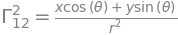

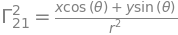

In [11]:
sys1.christoffel_symbols(kind=2)

#### Coefficients of grad a

In [12]:
sys1.grad_vector_coeff(basis="covariant")

               ⎡                               d                               ↪
               ⎢                               ──(a_{1})                       ↪
               ⎢                               dr                              ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢  a_{1}⋅(-x⋅sin(θ) + y⋅cos(θ))   a_{2}⋅(x⋅cos(θ) + y⋅sin(θ))   ↪
[a_{i}|_{j}] = ⎢- ──────────────────────────── - ─────────────────────────── + ↪
               ⎢               r                              2                ↪
               ⎢                                             r                 ↪
               ⎢                                                               ↪
               ⎢                               d                               ↪
               ⎢                               ──(a_{3})                       ↪
               ⎣            

In [13]:
sys1.grad_vector_coeff(basis="contravariant")

                ⎡                               d                              ↪
                ⎢                               ──(a__{1})                     ↪
                ⎢                               dr                             ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢a__{1}⋅(-x⋅sin(θ) + y⋅cos(θ))   a__{2}⋅(x⋅cos(θ) + y⋅sin(θ))  ↪
[a_{j}]__{i}| = ⎢───────────────────────────── + ────────────────────────────  ↪
                ⎢              r                               2               ↪
                ⎢                                             r                ↪
                ⎢                                                              ↪
                ⎢                               d                              ↪
                ⎢                               ──(a__{3})                     ↪
                ⎣           

#### Coefficients of grad T

In [14]:
sys1.grad_tensor_coeff(basis=1)

                 ⎡T__{12}⋅(-x⋅sin(θ) + y⋅cos(θ))   T__{21}⋅(-x⋅sin(θ) + y⋅cos( ↪
                 ⎢────────────────────────────── + ─────────────────────────── ↪
                 ⎢              r                                r             ↪
                 ⎢                                                             ↪
                 ⎢T__{12}⋅(x⋅cos(θ) + y⋅sin(θ))   T__{22}⋅(-x⋅sin(θ) + y⋅cos(θ ↪
                 ⎢───────────────────────────── + ──────────────────────────── ↪
[T_{0}]__{ij}| = ⎢              2                               r              ↪
                 ⎢             r                                               ↪
                 ⎢                                                             ↪
                 ⎢                T__{23}⋅(-x⋅sin(θ) + y⋅cos(θ))   d           ↪
                 ⎢                ────────────────────────────── + ──(T__{13}) ↪
                 ⎣                              r                  dr          ↪

↪ θ))   d            2⋅T__{

                 ⎡T__{21}⋅(x⋅cos(θ) + y⋅sin(θ))   T__{22}⋅(-x⋅sin(θ) + y⋅cos(θ ↪
                 ⎢───────────────────────────── + ──────────────────────────── ↪
                 ⎢              2                               r              ↪
                 ⎢             r                                               ↪
                 ⎢                                                             ↪
                 ⎢               2⋅T__{22}⋅(x⋅cos(θ) + y⋅sin(θ))   d           ↪
                 ⎢               ─────────────────────────────── + ──(T__{22}) ↪
[T_{1}]__{ij}| = ⎢                              2                  dr          ↪
                 ⎢                             r                               ↪
                 ⎢                                                             ↪
                 ⎢                T__{23}⋅(x⋅cos(θ) + y⋅sin(θ))   d            ↪
                 ⎢                ───────────────────────────── + ──(T__{23})  ↪
                 ⎢          

                 ⎡T__{32}⋅(-x⋅sin(θ) + y⋅cos(θ))   d            T__{31}⋅(-x⋅si ↪
                 ⎢────────────────────────────── + ──(T__{31})  ────────────── ↪
                 ⎢              r                  dr                          ↪
                 ⎢                                                             ↪
                 ⎢T__{32}⋅(x⋅cos(θ) + y⋅sin(θ))   d             T__{31}⋅(x⋅cos ↪
                 ⎢───────────────────────────── + ──(T__{32})   ────────────── ↪
[T_{2}]__{ij}| = ⎢              2                 dr                           ↪
                 ⎢             r                                             r ↪
                 ⎢                                                             ↪
                 ⎢                d                                            ↪
                 ⎢                ──(T__{33})                                  ↪
                 ⎣                dr                                           ↪

↪ n(θ) + y⋅cos(θ))         

In [15]:
sys1.grad_tensor_coeff(basis=2)

                ⎡                                d                             ↪
                ⎢                                ──(T_{11})                    ↪
                ⎢                                dr                            ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢  T_{11}⋅(-x⋅sin(θ) + y⋅cos(θ))   T_{12}⋅(x⋅cos(θ) + y⋅sin(θ) ↪
                ⎢- ───────────────────────────── - ─────────────────────────── ↪
[T_{ij}|_{0}] = ⎢                r                               2             ↪
                ⎢                                               r              ↪
                ⎢                                                              ↪
                ⎢                                d                             ↪
                ⎢                                ──(T_{13})                    ↪
                ⎢           

                ⎡    T_{11}⋅(-x⋅sin(θ) + y⋅cos(θ))   T_{12}⋅(x⋅cos(θ) + y⋅sin( ↪
                ⎢  - ───────────────────────────── - ───────────────────────── ↪
                ⎢                  r                               2           ↪
                ⎢                                                 r            ↪
                ⎢                                                              ↪
                ⎢  2⋅T_{21}⋅(-x⋅sin(θ) + y⋅cos(θ))   2⋅T_{22}⋅(x⋅cos(θ) + y⋅si ↪
                ⎢- ─────────────────────────────── - ───────────────────────── ↪
[T_{ij}|_{1}] = ⎢                 r                                 2          ↪
                ⎢                                                  r           ↪
                ⎢                                                              ↪
                ⎢    T_{31}⋅(-x⋅sin(θ) + y⋅cos(θ))   T_{32}⋅(x⋅cos(θ) + y⋅sin( ↪
                ⎢  - ───────────────────────────── - ───────────────────────── ↪
                ⎢           

                ⎡                                d                             ↪
                ⎢                                ──(T_{31})                    ↪
                ⎢                                dr                            ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢  T_{31}⋅(-x⋅sin(θ) + y⋅cos(θ))   T_{32}⋅(x⋅cos(θ) + y⋅sin(θ) ↪
[T_{ij}|_{2}] = ⎢- ───────────────────────────── - ─────────────────────────── ↪
                ⎢                r                               2             ↪
                ⎢                                               r              ↪
                ⎢                                                              ↪
                ⎢                                d                             ↪
                ⎢                                ──(T_{33})                    ↪
                ⎣           

In [16]:
sys1.grad_tensor_coeff(basis=3)

                     ⎡                                     T_{.1}__{2}⋅(-x⋅sin ↪
                     ⎢                                     ─────────────────── ↪
                     ⎢                                                     r   ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢  T_{.1}__{1}⋅(-x⋅sin(θ) + y⋅cos(θ))   T_{.2}__{1}⋅(x⋅co ↪
[T_{.j}|_{0}]__{i} = ⎢- ────────────────────────────────── - ───────────────── ↪
                     ⎢                  r                                    2 ↪
                     ⎢                                                      r  ↪
                     ⎢                                                         ↪
                     ⎢                                     T_{.3}__{2}⋅(-x⋅sin ↪
                     ⎢                                     ─────────────────── ↪
                     ⎣      

                     ⎡ T_{.1}__{2}⋅(x⋅cos(θ) + y⋅sin(θ))   d                   ↪
                     ⎢ ───────────────────────────────── + ──(T_{.1}__{2})     ↪
                     ⎢                 2                   dr                  ↪
                     ⎢                r                                        ↪
                     ⎢                                                         ↪
                     ⎢  T_{.1}__{2}⋅(-x⋅sin(θ) + y⋅cos(θ))   d                 ↪
                     ⎢- ────────────────────────────────── + ──(T_{.2}__{2})   ↪
[T_{.j}|_{1}]__{i} = ⎢                  r                    dr                ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢ T_{.3}__{2}⋅(x⋅cos(θ) + y⋅sin(θ))   d                   ↪
                     ⎢ ───────────────────────────────── + ──(T_{.3}__{2})     ↪
                     ⎢      

                     ⎡                                     d                   ↪
                     ⎢                                     ──(T_{.1}__{3})     ↪
                     ⎢                                     dr                  ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢  T_{.1}__{3}⋅(-x⋅sin(θ) + y⋅cos(θ))   T_{.2}__{3}⋅(x⋅co ↪
[T_{.j}|_{2}]__{i} = ⎢- ────────────────────────────────── - ───────────────── ↪
                     ⎢                  r                                    2 ↪
                     ⎢                                                      r  ↪
                     ⎢                                                         ↪
                     ⎢                                     d                   ↪
                     ⎢                                     ──(T_{.3}__{3})     ↪
                     ⎣      

#### div a

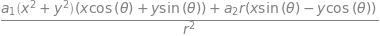

In [17]:
display(sp.simplify(sys1.div(a_).subs({sys1.u_expr[i] : sys1.u[i] for i in range(3)})))

#### div T

In [18]:
display(sp.simplify(sp.Matrix(sys1.div(T_)).subs({sys1.u_expr[i] : sys1.u[i] for i in range(3)})))

⎡                                                                              ↪
⎢-r⋅(-3⋅T__{22}⋅r⋅(x⋅sin(θ) - y⋅cos(θ)) + (T__{12} + 2⋅T__{21})⋅(x⋅cos(θ) + y⋅ ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢r⋅(-3⋅T__{22}⋅r⋅(x⋅sin(θ) - y⋅cos(θ)) + (T__{12} + 2⋅T__{21})⋅(x⋅cos(θ) + y⋅s ↪
⎢───────────────────────────────────────────────────────────────────────────── ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                                                                              ↪
⎢                           

<br> <br>
## Spherical Coordinate System

#### Initialization

In [19]:
def init2__ ():
    x, y, z, r, theta, phi = sp.symbols("x y z r theta phi")
    x_ = sp.Matrix([x, y, z])
    u_ = sp.Matrix([r, theta, phi])
    x_expr = sp.Matrix([r*sp.sin(phi)*sp.cos(theta), r*sp.sin(phi)*sp.sin(theta), r*sp.cos(phi)])
    u_expr = sp.Matrix([sp.sqrt(x**2 + y**2 + z**2), sp.atan(y/x), sp.acos(z/r)])
    return [x_, u_, x_expr, u_expr]

In [20]:
temp2 = init2__()
sys2 = Tensors(temp2[0], temp2[1], temp2[2], temp2[3])

#### Covariant Basis

In [21]:
sys2.covariant_basis()

        ⎡sin(φ)⋅cos(θ)⎤
        ⎢             ⎥
g_{1} = ⎢sin(φ)⋅sin(θ)⎥
        ⎢             ⎥
        ⎣   cos(φ)    ⎦

        ⎡-r⋅sin(φ)⋅sin(θ)⎤
        ⎢                ⎥
g_{2} = ⎢r⋅sin(φ)⋅cos(θ) ⎥
        ⎢                ⎥
        ⎣       0        ⎦

        ⎡r⋅cos(φ)⋅cos(θ)⎤
        ⎢               ⎥
g_{3} = ⎢r⋅sin(θ)⋅cos(φ)⎥
        ⎢               ⎥
        ⎣   -r⋅sin(φ)   ⎦

#### Contravariant Basis

In [22]:
sys2.contravariant_basis()

         ⎡x⎤
         ⎢─⎥
         ⎢r⎥
         ⎢ ⎥
         ⎢y⎥
g__{1} = ⎢─⎥
         ⎢r⎥
         ⎢ ⎥
         ⎢z⎥
         ⎢─⎥
         ⎣r⎦

         ⎡  -y   ⎤
         ⎢───────⎥
         ⎢ 2    2⎥
         ⎢x  + y ⎥
         ⎢       ⎥
g__{2} = ⎢   x   ⎥
         ⎢───────⎥
         ⎢ 2    2⎥
         ⎢x  + y ⎥
         ⎢       ⎥
         ⎣   0   ⎦

         ⎡       0        ⎤
         ⎢                ⎥
         ⎢       0        ⎥
         ⎢                ⎥
         ⎢      -1        ⎥
         ⎢────────────────⎥
g__{3} = ⎢        ________⎥
         ⎢       ╱      2 ⎥
         ⎢      ╱      z  ⎥
         ⎢r⋅   ╱   1 - ── ⎥
         ⎢    ╱         2 ⎥
         ⎣  ╲╱         r  ⎦

#### Metric Tensor

In [23]:
sys2.metric_tensor()

           ⎡1      0       0 ⎤
           ⎢                 ⎥
           ⎢    2    2       ⎥
[g_{ij}] = ⎢0  r ⋅sin (φ)  0 ⎥
           ⎢                 ⎥
           ⎢                2⎥
           ⎣0      0       r ⎦

In [24]:
sys2.metric_tensor(inv=True)

            ⎡                                                            -z    ↪
            ⎢                1                      0     ──────────────────── ↪
            ⎢                                                     ________     ↪
            ⎢                                                    ╱      2      ↪
            ⎢                                                   ╱      z     ╱ ↪
            ⎢                                             r⋅   ╱   1 - ── ⋅╲╱  ↪
            ⎢                                                 ╱         2      ↪
            ⎢                                               ╲╱         r       ↪
            ⎢                                                                  ↪
            ⎢                                       1                          ↪
            ⎢                0                   ───────                  0    ↪
[g__{ij}] = ⎢                                     2    2                       ↪
            ⎢               

#### Christoffel Symbols of 1st Kind

In [25]:
sys2.christoffel_symbols(kind=1)

#### Christoffel Symbols of 2nd Kind

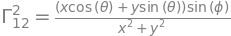

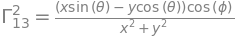

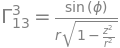

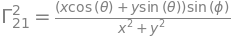

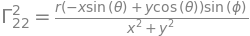

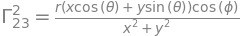

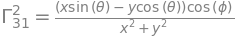

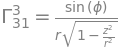

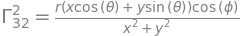

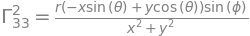

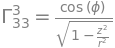

In [26]:
sys2.christoffel_symbols(kind=2)

#### Coefficients of grad a

In [27]:
sys2.grad_vector_coeff(basis="covariant")

               ⎡                                                        d      ↪
               ⎢                                                        ──(a_{ ↪
               ⎢                                                        dr     ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                    a_{1}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅sin(φ)   a_{2 ↪
               ⎢                  - ─────────────────────────────────── - ──── ↪
[a_{i}|_{j}] = ⎢                                     r                         ↪
               ⎢            

In [28]:
sys2.grad_vector_coeff(basis="contravariant")

                ⎡                                                        d     ↪
                ⎢                                                        ──(a_ ↪
                ⎢                                                        dr    ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                  a__{1}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅sin(φ)   a__{ ↪
                ⎢                  ──────────────────────────────────── + ──── ↪
[a_{j}]__{i}| = ⎢                                   r                          ↪
                ⎢           

#### Coefficients of grad T

In [29]:
sys2.grad_tensor_coeff(basis=1)

                 ⎡T__{12}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅sin(φ)   T__{13}⋅(x⋅cos(φ)⋅co ↪
                 ⎢───────────────────────────────────── + ──────────────────── ↪
                 ⎢                  r                                          ↪
                 ⎢                                                             ↪
                 ⎢         T__{12}⋅(x⋅cos(θ) + y⋅sin(θ))⋅sin(φ)   T__{13}⋅(x⋅s ↪
                 ⎢         ──────────────────────────────────── + ──────────── ↪
                 ⎢                        2    2                               ↪
                 ⎢                       x  + y                                ↪
[T_{0}]__{ij}| = ⎢                                                             ↪
                 ⎢                                        T__{13}⋅sin(φ)    T_ ↪
                 ⎢                                       ──────────────── + ── ↪
                 ⎢                                               ________      ↪
                 ⎢          

                 ⎡T__{21}⋅(x⋅cos(θ) + y⋅sin(θ))⋅sin(φ)   T__{22}⋅(-x⋅sin(θ) +  ↪
                 ⎢──────────────────────────────────── + ───────────────────── ↪
                 ⎢               2    2                                    r   ↪
                 ⎢              x  + y                                         ↪
                 ⎢                                                             ↪
                 ⎢                            2⋅T__{22}⋅(x⋅cos(θ) + y⋅sin(θ))⋅ ↪
                 ⎢                            ──────────────────────────────── ↪
                 ⎢                                            2    2           ↪
                 ⎢                                           x  + y            ↪
[T_{1}]__{ij}| = ⎢                                                             ↪
                 ⎢                                       T__{23}⋅(x⋅cos(θ) + y ↪
                 ⎢                                       ───────────────────── ↪
                 ⎢          

                 ⎡ T__{31}⋅sin(φ)    T__{32}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅sin(φ)   T ↪
                 ⎢──────────────── + ───────────────────────────────────── + ─ ↪
                 ⎢        ________                     r                       ↪
                 ⎢       ╱      2                                              ↪
                 ⎢      ╱      z                                               ↪
                 ⎢r⋅   ╱   1 - ──                                              ↪
                 ⎢    ╱         2                                              ↪
                 ⎢  ╲╱         r                                               ↪
                 ⎢                                                             ↪
                 ⎢         T__{32}⋅(x⋅cos(θ) + y⋅sin(θ))⋅sin(φ)    T__{32}⋅sin ↪
                 ⎢         ──────────────────────────────────── + ──────────── ↪
                 ⎢                        2    2                          ____ ↪
                 ⎢          

In [30]:
sys2.grad_tensor_coeff(basis=2)

                ⎡                                                         d    ↪
                ⎢                                                         ──(T ↪
                ⎢                                                         dr   ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                    T_{11}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅sin(φ)   T_ ↪
                ⎢                  - ──────────────────────────────────── - ── ↪
                ⎢                                     r                        ↪
                ⎢           

                ⎡                                                          T_{ ↪
                ⎢                                                        - ─── ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                        2⋅T_{ ↪
                ⎢                                                      - ───── ↪
[T_{ij}|_{1}] = ⎢                                                              ↪
                ⎢           

                ⎡                                        T_{11}⋅(x⋅cos(φ)⋅cos( ↪
                ⎢                                      - ───────────────────── ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢  T_{21}⋅(x⋅cos(φ)⋅cos(θ) + y⋅sin(θ)⋅cos(φ) - z⋅sin(φ))   T_{ ↪
                ⎢- ───────────────────────────────────────────────────── - ─── ↪
                ⎢                            r                                 ↪
                ⎢           

In [31]:
sys2.grad_tensor_coeff(basis=3)

                     ⎡                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                     T_{.1}__{1}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅ ↪
                     ⎢                   - ─────────────────────────────────── ↪
[T_{.j}|_{0}]__{i} = ⎢                                         r               ↪
                     ⎢      

                     ⎡                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
[T_{.j}|_{1}]__{i} = ⎢                                                         ↪
                     ⎢      

                     ⎡                                            T_{.1}__{3}⋅ ↪
                     ⎢                                            ──────────── ↪
                     ⎢                                                     ___ ↪
                     ⎢                                                    ╱    ↪
                     ⎢                                                   ╱     ↪
                     ⎢                                             r⋅   ╱   1  ↪
                     ⎢                                                 ╱       ↪
                     ⎢                                               ╲╱        ↪
                     ⎢                                                         ↪
                     ⎢  T_{.1}__{3}⋅(-x⋅sin(θ) + y⋅cos(θ))⋅sin(φ)   T_{.2}__{3 ↪
                     ⎢- ───────────────────────────────────────── - ────────── ↪
                     ⎢                      r                                  ↪
                     ⎢      

#### div a

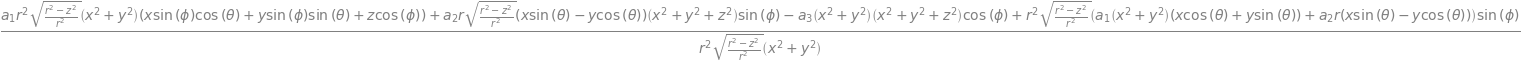

In [32]:
display(sp.simplify(sys2.div(a_).subs({sys2.u_expr[i] : sys2.u[i] for i in range(3)})))

#### div T

In [33]:
display(sp.Matrix(sys2.div(T_)))

⎡  ⎛ T__{13}⋅sin(φ)    T__{31}⋅(x⋅cos(θ) + y⋅sin(θ))⋅sin(φ)   2⋅T__{31}⋅sin(φ) ↪
⎢r⋅⎜──────────────── + ──────────────────────────────────── + ──────────────── ↪
⎢  ⎜        ________                  2    2                          ________ ↪
⎢  ⎜       ╱      2                  x  + y                          ╱      2  ↪
⎢  ⎜      ╱      z                                                  ╱      z   ↪
⎢  ⎜r⋅   ╱   1 - ──                                           r⋅   ╱   1 - ──  ↪
⎢  ⎜    ╱         2                                               ╱         2  ↪
⎢  ⎝  ╲╱         r                                              ╲╱         r   ↪
⎢                                                                              ↪
⎢  ⎛ T__{13}⋅sin(φ)    T__{31}⋅(x⋅cos(θ) + y⋅sin(θ))⋅sin(φ)   2⋅T__{31}⋅sin(φ) ↪
⎢r⋅⎜──────────────── + ──────────────────────────────────── + ──────────────── ↪
⎢  ⎜        ________                  2    2                          ________ ↪
⎢  ⎜       ╱      2         

<br> <br>
## Toroidal Coordinate System

In [34]:
def init3__():
    x, y, z, r, theta, phi, R = sp.symbols("x y z r theta phi, R")
    x_ = sp.Matrix([x, y, z])
    u_ = sp.Matrix([r, theta, phi])
    x_expr = sp.Matrix([(R - r*sp.cos(theta)) * sp.cos(phi), (R - r*sp.cos(theta)) * sp.sin(phi), r * sp.sin(theta)])
    u_expr = sp.Matrix([sp.sqrt((R - sp.sqrt(x**2 + y**2))**2 + z**2), sp.atan(z / (R - sp.sqrt(x**2 + y**2))), sp.atan(y/x)])
    return [x_, u_, x_expr, u_expr]

In [35]:
temp3 = init3__()
sys3 = Tensors(temp3[0], temp3[1], temp3[2], temp3[3])

#### Covariant Basis

In [36]:
sys3.covariant_basis()

        ⎡-cos(φ)⋅cos(θ)⎤
        ⎢              ⎥
g_{1} = ⎢-sin(φ)⋅cos(θ)⎥
        ⎢              ⎥
        ⎣    sin(θ)    ⎦

        ⎡r⋅sin(θ)⋅cos(φ)⎤
        ⎢               ⎥
g_{2} = ⎢r⋅sin(φ)⋅sin(θ)⎥
        ⎢               ⎥
        ⎣   r⋅cos(θ)    ⎦

        ⎡(-R + r⋅cos(θ))⋅sin(φ)⎤
        ⎢                      ⎥
g_{3} = ⎢(R - r⋅cos(θ))⋅cos(φ) ⎥
        ⎢                      ⎥
        ⎣          0           ⎦

#### Contravariant Basis

In [37]:
sys3.contravariant_basis()

         ⎡   ⎛       _________⎞ ⎤
         ⎢   ⎜      ╱  2    2 ⎟ ⎥
         ⎢-x⋅⎝R - ╲╱  x  + y  ⎠ ⎥
         ⎢──────────────────────⎥
         ⎢         _________    ⎥
         ⎢        ╱  2    2     ⎥
         ⎢    r⋅╲╱  x  + y      ⎥
         ⎢                      ⎥
         ⎢   ⎛       _________⎞ ⎥
g__{1} = ⎢   ⎜      ╱  2    2 ⎟ ⎥
         ⎢-y⋅⎝R - ╲╱  x  + y  ⎠ ⎥
         ⎢──────────────────────⎥
         ⎢         _________    ⎥
         ⎢        ╱  2    2     ⎥
         ⎢    r⋅╲╱  x  + y      ⎥
         ⎢                      ⎥
         ⎢          z           ⎥
         ⎢          ─           ⎥
         ⎣          r           ⎦

         ⎡      x⋅z       ⎤
         ⎢─────────────── ⎥
         ⎢      _________ ⎥
         ⎢ 2   ╱  2    2  ⎥
         ⎢r ⋅╲╱  x  + y   ⎥
         ⎢                ⎥
         ⎢      y⋅z       ⎥
         ⎢─────────────── ⎥
         ⎢      _________ ⎥
g__{2} = ⎢ 2   ╱  2    2  ⎥
         ⎢r ⋅╲╱  x  + y   ⎥
         ⎢                ⎥
         ⎢       _________⎥
         ⎢      ╱  2    2 ⎥
         ⎢R - ╲╱  x  + y  ⎥
         ⎢────────────────⎥
         ⎢        2       ⎥
         ⎣       r        ⎦

         ⎡  -y   ⎤
         ⎢───────⎥
         ⎢ 2    2⎥
         ⎢x  + y ⎥
         ⎢       ⎥
g__{3} = ⎢   x   ⎥
         ⎢───────⎥
         ⎢ 2    2⎥
         ⎢x  + y ⎥
         ⎢       ⎥
         ⎣   0   ⎦

#### Metric Tensor

In [38]:
sys3.metric_tensor()

           ⎡1  0          0       ⎤
           ⎢                      ⎥
           ⎢    2                 ⎥
[g_{ij}] = ⎢0  r          0       ⎥
           ⎢                      ⎥
           ⎢                     2⎥
           ⎣0  0   (R - r⋅cos(θ)) ⎦

In [39]:
sys3.metric_tensor(inv=True)

            ⎡1             0                 0   ⎤
            ⎢                                    ⎥
            ⎢              1                     ⎥
            ⎢0  ────────────────────────     0   ⎥
            ⎢                          2         ⎥
            ⎢        ⎛       _________⎞          ⎥
[g__{ij}] = ⎢    2   ⎜      ╱  2    2 ⎟          ⎥
            ⎢   z  + ⎝R - ╲╱  x  + y  ⎠          ⎥
            ⎢                                    ⎥
            ⎢                                1   ⎥
            ⎢0             0              ───────⎥
            ⎢                              2    2⎥
            ⎣                             x  + y ⎦

#### Christoffel Symbols of 1st Kind

In [40]:
sys3.christoffel_symbols(kind=1)

#### Christoffel Symbols of 2nd Kind

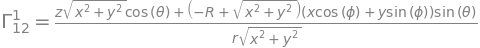

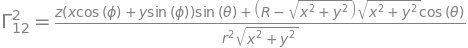

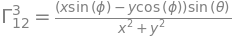

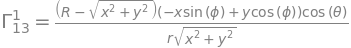

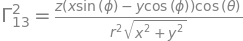

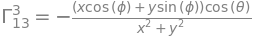

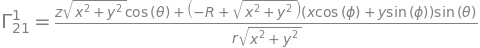

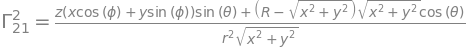

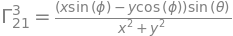

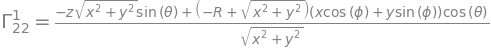

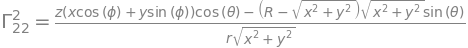

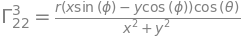

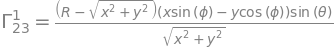

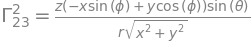

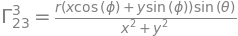

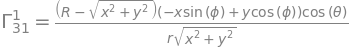

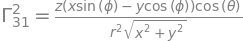

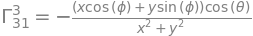

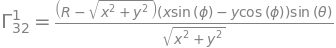

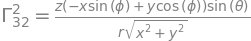

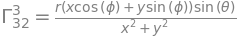

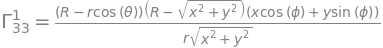

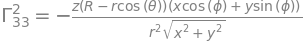

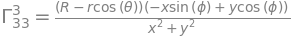

In [41]:
sys3.christoffel_symbols(kind=2)

#### Coefficients of grad a

In [42]:
sys3.grad_vector_coeff(basis="covariant")

               ⎡                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢                                                               ↪
               ⎢        ⎛     _________          ⎛        _________⎞           ↪
               ⎢        ⎜    ╱  2    2           ⎜       ╱  2    2 ⎟           ↪
               ⎢  a_{1}⋅⎝z⋅╲╱  x  + y  ⋅cos(θ) + ⎝-R + ╲╱  x  + y  ⎠⋅(x⋅cos(φ) ↪
[a_{i}|_{j}] = ⎢- ──────────────────────────────────────────────────────────── ↪
               ⎢            

In [43]:
sys3.grad_vector_coeff(basis="contravariant")

                ⎡                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢       ⎛     _________          ⎛        _________⎞           ↪
                ⎢       ⎜    ╱  2    2           ⎜       ╱  2    2 ⎟           ↪
                ⎢a__{1}⋅⎝z⋅╲╱  x  + y  ⋅cos(θ) + ⎝-R + ╲╱  x  + y  ⎠⋅(x⋅cos(φ) ↪
[a_{j}]__{i}| = ⎢───────────────────────────────────────────────────────────── ↪
                ⎢           

#### Coefficients of grad T

In [44]:
sys3.grad_tensor_coeff(basis=1)

                 ⎡        ⎛     _________          ⎛        _________⎞         ↪
                 ⎢        ⎜    ╱  2    2           ⎜       ╱  2    2 ⎟         ↪
                 ⎢T__{12}⋅⎝z⋅╲╱  x  + y  ⋅cos(θ) + ⎝-R + ╲╱  x  + y  ⎠⋅(x⋅cos( ↪
                 ⎢──────────────────────────────────────────────────────────── ↪
                 ⎢                                       _________             ↪
                 ⎢                                      ╱  2    2              ↪
                 ⎢                                  r⋅╲╱  x  + y               ↪
                 ⎢                                                             ↪
                 ⎢                 ⎛                                 ⎛       _ ↪
                 ⎢                 ⎜                                 ⎜      ╱  ↪
                 ⎢         T__{12}⋅⎝z⋅(x⋅cos(φ) + y⋅sin(φ))⋅sin(θ) + ⎝R - ╲╱   ↪
[T_{0}]__{ij}| = ⎢         ─────────────────────────────────────────────────── ↪
                 ⎢          

                 ⎡        ⎛                                 ⎛       _________⎞ ↪
                 ⎢        ⎜                                 ⎜      ╱  2    2 ⎟ ↪
                 ⎢T__{21}⋅⎝z⋅(x⋅cos(φ) + y⋅sin(φ))⋅sin(θ) + ⎝R - ╲╱  x  + y  ⎠ ↪
                 ⎢──────────────────────────────────────────────────────────── ↪
                 ⎢                                       _________             ↪
                 ⎢                                  2   ╱  2    2              ↪
                 ⎢                                 r ⋅╲╱  x  + y               ↪
                 ⎢                                                             ↪
                 ⎢                                                             ↪
                 ⎢                                                             ↪
                 ⎢                                                  2⋅T__{22}⋅ ↪
[T_{1}]__{ij}| = ⎢                                                  ────────── ↪
                 ⎢          

                 ⎡                                                             ↪
                 ⎢                                                             ↪
                 ⎢T__{21}⋅(x⋅sin(φ) - y⋅cos(φ))⋅sin(θ)   T__{31}⋅(x⋅cos(φ) + y ↪
                 ⎢──────────────────────────────────── - ───────────────────── ↪
                 ⎢               2    2                                 2    2 ↪
                 ⎢              x  + y                                 x  + y  ↪
                 ⎢                                                             ↪
                 ⎢                                                             ↪
                 ⎢                                                             ↪
                 ⎢                                                             ↪
[T_{2}]__{ij}| = ⎢         T__{22}⋅(x⋅sin(φ) - y⋅cos(φ))⋅sin(θ)   T__{32}⋅(x⋅c ↪
                 ⎢         ──────────────────────────────────── - ──────────── ↪
                 ⎢          

In [45]:
sys3.grad_tensor_coeff(basis=2)

                ⎡                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢         ⎛     _________          ⎛        _________⎞         ↪
                ⎢         ⎜    ╱  2    2           ⎜       ╱  2    2 ⎟         ↪
                ⎢  T_{11}⋅⎝z⋅╲╱  x  + y  ⋅cos(θ) + ⎝-R + ╲╱  x  + y  ⎠⋅(x⋅cos( ↪
[T_{ij}|_{0}] = ⎢- ─────────────────────────────────────────────────────────── ↪
                ⎢           

                ⎡                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
[T_{ij}|_{1}] = ⎢                                                              ↪
                ⎢           

                ⎡                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢                                                              ↪
                ⎢         ⎛       _________⎞                                   ↪
                ⎢         ⎜      ╱  2    2 ⎟                                   ↪
                ⎢  T_{21}⋅⎝R - ╲╱  x  + y  ⎠⋅(-x⋅sin(φ) + y⋅cos(φ))⋅cos(θ)   T ↪
[T_{ij}|_{2}] = ⎢- ─────────────────────────────────────────────────────── - ─ ↪
                ⎢           

In [46]:
sys3.grad_tensor_coeff(basis=3)

                     ⎡                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢              ⎛     _________          ⎛        ________ ↪
                     ⎢              ⎜    ╱  2    2           ⎜       ╱  2    2 ↪
                     ⎢  T_{.1}__{1}⋅⎝z⋅╲╱  x  + y  ⋅cos(θ) + ⎝-R + ╲╱  x  + y  ↪
[T_{.j}|_{0}]__{i} = ⎢- ────────────────────────────────────────────────────── ↪
                     ⎢      

                     ⎡                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                       T ↪
[T_{.j}|_{1}]__{i} = ⎢                                                     - ─ ↪
                     ⎢      

                     ⎡                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                         ↪
                     ⎢                                                       ⎛ ↪
                     ⎢                                                       ⎜ ↪
                     ⎢T_{.2}__{2}⋅(x⋅sin(φ) - y⋅cos(φ))⋅sin(θ)   T_{.1}__{3}⋅⎝ ↪
[T_{.j}|_{2}]__{i} = ⎢──────────────────────────────────────── - ───────────── ↪
                     ⎢      

#### div a

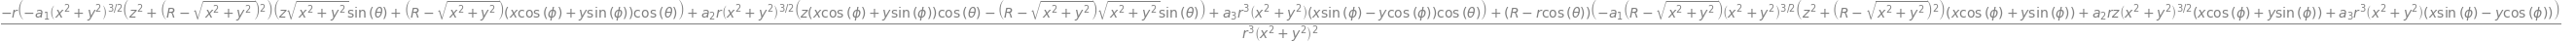

In [47]:
display(sp.simplify(sys3.div(a_).subs({sys3.u_expr[i] : sys3.u[i] for i in range(3)})))

#### div T

In [48]:
display(sp.Matrix(sys3.div(T_)))

⎡  ⎛        ⎛                                 ⎛       _________⎞    _________  ↪
⎢  ⎜        ⎜                                 ⎜      ╱  2    2 ⎟   ╱  2    2   ↪
⎢  ⎜T__{12}⋅⎝z⋅(x⋅cos(φ) + y⋅sin(φ))⋅sin(θ) + ⎝R - ╲╱  x  + y  ⎠⋅╲╱  x  + y  ⋅ ↪
⎢r⋅⎜────────────────────────────────────────────────────────────────────────── ↪
⎢  ⎜                                  ⎛                       2⎞               ↪
⎢  ⎜                        _________ ⎜     ⎛       _________⎞ ⎟               ↪
⎢  ⎜                       ╱  2    2  ⎜ 2   ⎜      ╱  2    2 ⎟ ⎟               ↪
⎢  ⎜                     ╲╱  x  + y  ⋅⎝z  + ⎝R - ╲╱  x  + y  ⎠ ⎠               ↪
⎢  ⎝                                                                           ↪
⎢                                                                              ↪
⎢  ⎛        ⎛                                 ⎛       _________⎞    _________  ↪
⎢  ⎜        ⎜                                 ⎜      ╱  2    2 ⎟   ╱  2    2   ↪
⎢  ⎜T__{12}⋅⎝z⋅(x⋅cos(φ) + y